In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
from tqdm.auto import tqdm
import os
tqdm.pandas()

# importing data_loader.py
os.chdir('/'.join(os.getcwd().split('\\')[:-1]))
from utils.loader import data_loader

In [2]:
BATCH_SIZE = 64
EMBEDDING_DIM = 50
UNITS = 50
NUM_EPOCHS = 35

In [3]:
train_dataset, test_dataset, inp_lang, tgt_lang, max_length_inp, max_length_tgt = data_loader(
    'datasets/hin.txt', BATCH_SIZE)

In [4]:
vocab_inp_size = len(inp_lang.word2idx)
vocab_tgt_size = len(tgt_lang.word2idx)

In [5]:
def detokenize(tokens, idx2word):
    text = ""
    for t in tokens:
        if 'tensorflow' in str(type(tokens)):
            text += idx2word[t.numpy()] + ' '
        else:
            text += idx2word[t] + ' '
    text = text.replace(' <pad>', '')
    text = text.replace('<start>', '')
    text = text.replace('<end>', '')
    return text.strip()

In [6]:
eng, hin = next(iter(train_dataset))
print('Shape:', eng.shape, hin.shape)
print('English Sentence:', detokenize(eng[0], inp_lang.idx2word))
print('Hindi Sentence: ', detokenize(hin[0], tgt_lang.idx2word))

Shape: (64, 22) (64, 27)
English Sentence: wheres my book
Hindi Sentence:  मेरी किताब कहाँ है


In [7]:
class Encoder(tf.keras.layers.Layer):
    
    def __init__(self, embed_dim, units, vocab_size):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(
            vocab_size, embed_dim, mask_zero=True)
        self.rnn = tf.keras.layers.LSTM(
            units, return_sequences=True, return_state=True)
    
    def call(self, x):
        # x => (batch_size, max_len)
        x = self.embedding(x) # => (batch_size, s, embed_dim)
        enc_outputs = self.rnn(x)
        return enc_outputs[0], enc_outputs[1:]

In [8]:
tmp_enc_outputs, tmp_enc_state = Encoder(
    EMBEDDING_DIM, UNITS, vocab_inp_size
)(eng)

print(tmp_enc_outputs.shape, tmp_enc_state[-1].shape)

(64, 22, 50) (64, 50)


In [9]:
tf.random.normal((2, 1, 4))

<tf.Tensor: shape=(2, 1, 4), dtype=float32, numpy=
array([[[ 0.9393754 , -0.693225  ,  0.18198591, -0.11582617]],

       [[-2.3974476 ,  0.41746533,  0.30246198, -0.9680312 ]]],
      dtype=float32)>

In [10]:
class AdditiveAttention(tf.keras.layers.Layer):

    def __init__(self, units):
        super().__init__()
        self.W_q = tf.keras.layers.Dense(units, use_bias=False)
        self.W_k = tf.keras.layers.Dense(units, use_bias=False)
        self.W_v = tf.keras.layers.Dense(1, use_bias=False)
    

    def call(self, query, key, value, mask=None):
        query, key = self.W_q(query), self.W_k(key)
        # query => (batch_size, t, units)
        # key => (batch_size, s, units)

        score = self.W_v(
            tf.math.tanh(
                tf.expand_dims(query, 2) + tf.expand_dims(key, 1)
            )
        )
        score = tf.squeeze(score, -1)
        # score => (batch_size, t, s)
        
        if mask:
            score = tf.where(mask, score, -1e6)
        
        attention_weights = tf.nn.softmax(score, axis=-1)
        # attention_weights => (batch_size, t, s)

        context = tf.matmul(attention_weights, value)
        # context => (batch_size, t, units)

        return context, attention_weights

In [11]:
class Decoder(tf.keras.layers.Layer):

    def __init__(self, embed_dim, units, vocab_size):
        super().__init__()

        # Embedding layer to convert tokens to vectors
        self.embedding = tf.keras.layers.Embedding(
            vocab_size, embed_dim, mask_zero=True)
        
        # RNN layer
        self.rnn = tf.keras.layers.LSTM(
            units, return_sequences=True, return_state=True)
        
        # Attention layer
        self.attention = AdditiveAttention(units)

        # Final layer to output logits, we can use 
        # argmax to know which output token is predicted.
        self.fc = tf.keras.layers.Dense(vocab_size)
    

    def call(self, x, enc_outputs, state, mask=None):
        x = self.embedding(x)
        # x => (batch_size, t, embed_dim)

        dec_outputs = self.rnn(x, initial_state=state)
        output = dec_outputs[0]
        state = dec_outputs[1:]
        # output   => (batch_size, t, units) 
        # state[i] => (batch_size, s, units)

        context_vector, attention_weights = self.attention(
            query=output,
            key=enc_outputs,
            value=enc_outputs,
            mask=mask
        )
        # context_vector => (batch_size, t, units)
        # attention_weights => (batch_size, t, s)

        context_rnn_output = tf.concat(
            [context_vector, output], axis=-1)
        # context_rnn_output => (batch_size, t, 2*units)

        pred = self.fc(context_rnn_output)
        # pred => (batch_size, t, vocab_size)
        
        return pred, state, attention_weights

In [12]:
tmp_dec_output, tmp_dec_state, tmp_att_wghts = Decoder(
    EMBEDDING_DIM, UNITS, vocab_tgt_size
)(hin, tmp_enc_outputs, tmp_enc_state)

print(
    tmp_dec_output.shape, 
    tmp_dec_state[-1].shape, 
    tmp_att_wghts.shape
)

(64, 27, 3043) (64, 50) (64, 27, 22)


In [13]:
encoder = Encoder(EMBEDDING_DIM, UNITS, vocab_inp_size)
decoder = Decoder(EMBEDDING_DIM, UNITS, vocab_tgt_size)

In [14]:
def loss_fn(y_true, y_pred):
    # y_true => (batch_size, max_len)
    # y_pred => (batch_size, max_len, vocab_size)

    mask = tf.cast(y_true != 0, tf.float32)

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    # masking the padding tokens
    loss = tf.reduce_sum(loss * mask)
    return loss

In [15]:
trainer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [16]:
history = {
    'loss': []
}

In [17]:
for epoch in range(NUM_EPOCHS):
    total_loss = 0.

    with tqdm(total=len(train_dataset)) as pbar:
        for batch, (x, y) in enumerate(train_dataset):
            inp_mask = tf.expand_dims(x != 0, axis=1)
            tgt_mask = tf.cast(y != 0, tf.float32)
            
            with tf.GradientTape() as tape:
                loss = tf.constant(0.0)
                enc_outputs, enc_states = encoder(x)
                dec_states = enc_states

                dec_input = tf.expand_dims(y[:, 0], axis=1)
                for t in range(1, x.shape[1]):
                    dec_outputs, dec_states, tmp_a = decoder(
                        dec_input, enc_outputs, 
                        dec_states, inp_mask)

                    loss += loss_fn(
                        tf.expand_dims(y[:, t], axis=1), dec_outputs)
                    dec_input = tf.expand_dims(y[:, t], axis=1)
                    
                loss = loss/tf.reduce_sum(tgt_mask)
            
            variables = (encoder.trainable_variables + 
            decoder.trainable_variables)
            gradients = tape.gradient(loss, variables)
            trainer.apply_gradients(zip(gradients, variables))
            total_loss += loss.numpy()
            pbar.update(1)
        
    epoch_loss = total_loss/len(train_dataset)
    history['loss'].append(epoch_loss)
    print(f'Epoch: {epoch} | Loss: {epoch_loss}')

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 | Loss: 5.601614212989807


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 | Loss: 4.738621234893799


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2 | Loss: 4.390076494216919


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 | Loss: 4.033985942602158


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 | Loss: 3.6781422078609465


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5 | Loss: 3.330654126405716


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 | Loss: 2.9859378397464753


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 | Loss: 2.650220477581024


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 | Loss: 2.3180492401123045


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 | Loss: 2.0164569288492205


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10 | Loss: 1.731974157691002


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 | Loss: 1.4841306030750274


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 | Loss: 1.2645997732877732


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 | Loss: 1.092376634478569


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 | Loss: 0.9435681775212288


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15 | Loss: 0.816150389611721


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 | Loss: 0.7062206119298935


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 | Loss: 0.6120080262422561


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18 | Loss: 0.5387923933565617


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19 | Loss: 0.47646153196692465


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 20 | Loss: 0.4324882015585899


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 21 | Loss: 0.38220626935362817


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 22 | Loss: 0.3342899069190025


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 23 | Loss: 0.29908328391611577


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 24 | Loss: 0.2792776063084602


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 25 | Loss: 0.2621343653649092


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 26 | Loss: 0.23622720055282115


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 27 | Loss: 0.21275232583284379


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 28 | Loss: 0.18640515226870774


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 29 | Loss: 0.16350328531116248


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 30 | Loss: 0.1469208773225546


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 31 | Loss: 0.13151674401015043


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 32 | Loss: 0.11693754866719246


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 33 | Loss: 0.10731785278767347


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 34 | Loss: 0.09472120217978955


In [18]:
eng.shape, hin.shape

(TensorShape([64, 22]), TensorShape([64, 27]))

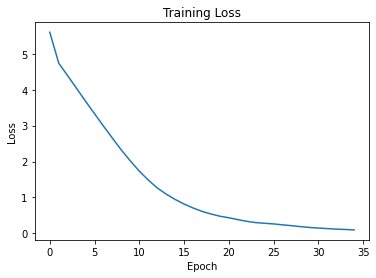

In [19]:
epochs = list(range(len(history['loss'])))
plt.plot(epochs, history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [29]:
def predict_seq2seq(encoder, decoder, src_tokens, tgt_vocab, num_steps):
    enc_X = tf.expand_dims(src_tokens, axis=0)
    mask = tf.expand_dims(enc_X != 0, 1)

    enc_outputs, enc_state = encoder(enc_X, training=False)
    dec_state = enc_state
    
    dec_X = tf.expand_dims(tf.constant([tgt_vocab.word2idx['<start>']]), axis=0)
    output_seq = []
    attention_weights = []
    for _ in range(num_steps):
        Y, dec_state, att_wgts = decoder(
            dec_X, enc_outputs, dec_state, mask,training=False)
        dec_X = tf.argmax(Y, axis=2)
        pred = tf.squeeze(dec_X, axis=0)
        if pred[0].numpy() == tgt_vocab.word2idx['<end>']:
            break
        output_seq.append(pred[0].numpy())
        attention_weights.append(tf.squeeze(att_wgts, 0))
        
    attention_weights = tf.squeeze(tf.stack(attention_weights, axis=0), 1)
    return detokenize(output_seq, tgt_vocab.idx2word), attention_weights

In [21]:
eng, hin = next(iter(train_dataset))

In [38]:
import plotly
from plotly.offline import init_notebook_mode, iplot
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objects as go

English Sentence:      a mother is responsible for the conduct of her children
Predicted Translation: एक माँ अपने बच्चों के बर्ताव के लिए ज़िम्मेदार होती है।
Actual Translation:    एक माँ अपने बच्चों के बर्ताव के लिए ज़िम्मेदार होती है।


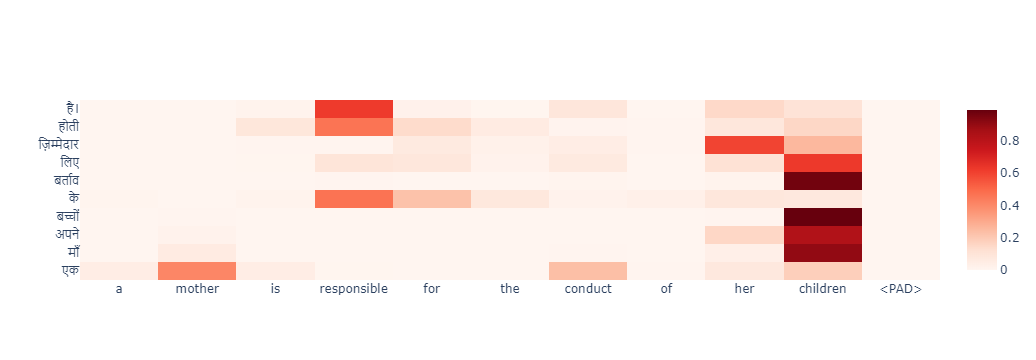

In [44]:
idx = -5
actual_seq = detokenize(hin[idx], tgt_lang.idx2word)
translation, att_wgts = predict_seq2seq(encoder, decoder, eng[idx], tgt_lang, max_length_tgt)

eng_sent = detokenize(eng[idx], inp_lang.idx2word)
print(f'English Sentence:      {eng_sent}')
print(f'Predicted Translation: {translation}')
print(f'Actual Translation:    {actual_seq}')


eng_tokens = eng_sent.strip().split(' ')
eng_tokens += ['<PAD>'] * (max_length_inp - len(eng_tokens))

trace = go.Heatmap(
    z=att_wgts, 
    x= eng_tokens, 
    y=translation.split(' '), 
    colorscale='Reds'
)
iplot([trace])